## AI6101 RL Assignment Code and Report

Syed Anas Majid  
G2204717J  
syed0062@e.ntu.edu.sg  

This jupyter notebook contains code to train an RL Agent using Q Learning to navigate a 2D grid world, and a report containing observations and analysis.

In [1]:
import copy
import math
import numpy as np
import pandas as pd
from typing import List, Tuple
import matplotlib.pyplot as plt
%matplotlib inline

## Overview

In the grid world, A indicates the agent, B indicates the box, G is the goal position. The grid squares marked x indicate a cliff that the agent or box should avoid. 

The game ends under three conditions:  
1. The box arrives at the goal.
2. The agent or box steps into the cliff region.
3. The maximum time step (incremented at every action that the agent takes) of 100 is reached.

This problem is formulated as an MDP, as follows:
- **State:** The state consists of the agent's position, as well as the box's position, and is represented as a tuple: (agent_x, agent_y, box_x, box_y)
- **Action:** The action space consists of 4 possible movements: [up, down, left, right]. These are represented numerically as [1, 2, 3, 4] respectively.
- **Reward:** The reward is calculated based on the agent's movement, as well as the distance of the box from the goal. The following is a summary of the reward elements:  
        a. the agent will receive a reward of -1 at each timestep  
        b. the negative value of the distance between the box and the goal  
        c. the negative value of the distance between the agent and the box  
        d. the agent will receive a reward of -1000 if the agent or the box falls into the cliff.  
        e. the agent will receive a reward of 1000 if the box reaches the goal position.
- **Transition:** Agent’s action can change its position and the position of the box. If a collision with a boundary happens, the agent or the box would stay in the same position.  
The transition can be seen in the step() function of the environment.

The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```



In [2]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        if self.render:
            self.world = np.chararray((self.world_height, self.world_width))
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """ 
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist

        # # add reward for agent moving the box
        # if all(self.agent_pos + force == self.box_pos):
        #     reward+=10
        # # # check dist between box and goal
        # # box_goal_dist = np.sum(np.abs(self.goal_pos - self.box_pos))
        # # reward += -box_goal_dist
        # # if agent is near the cliff
        # if self._check_near_cliff(self.agent_pos) or self._check_near_cliff(self.box_pos):
        #     reward += -100

        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True
        
        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True
        
        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info

    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1
        
        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1
                    
        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False
    

    def _check_near_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.adj_danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False



    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]].decode('UTF-8') not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

Here is one example random agent class:

In [3]:
class RandomAgent:
    def __init__(self, env, num_episodes):
        self.action_space = [1, 2, 3, 4]
        self.env = env
        self.num_episodes = num_episodes

    def act(self):
        """Returns a random choice of the available actions"""
        return np.random.choice(self.action_space)

    def learn(self):
        rewards = []
        
        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                action = self.act() 
                next_state, reward, done, info = self.env.step(action)
                cumulative_reward += reward
                state = next_state
            rewards.append(cumulative_reward)

        return rewards

You need to complete the learn() method of the following class to implement your RL algorithm.

## The RLAgent Class

The RL agent class uses Q-learning to to estimate the Q-values of different actions in each state, and these are stored in the Q-table. The Q-value of each distinct action at each dictinct state is stored in the location (state, action) in the Q-table. In this implementation, the Q-table is stored as a dictionary of dictionaries, which is first initialised to 0 for every action in every state, as follows:

>{  
>    state_0: {1: 0, 2: 0, 3: 0, 4: 0}  
>    state_1: {1: 0, 2: 0, 3: 0, 4: 0}  
>        .  
>        .  
>    state_n: {1: 0, 2: 0, 3: 0, 4: 0}  
>}  

When the agent explores the environment, it will iteratively update the values in Q(state, action), using the Bellman equation during training. The agent chooses a random action with a probability of a small value, _epsilon_, to facilitate the exploration of the world.

The other hyperparameters include _alpha_, the learning rate, and _gamma_, the discount factor.

The epsilon greedy algorithm is used to encourage exploration for the agent. The agent chooses to explore the environment by choosing a random action with a probability of epsilon. The agent exploits the reward using the previously learned knowledge otherwise.

The cosine annealing schedule [1] was chosen for the epsilon value so that the agent is more inclined to explore at the early episodes of training, and gradually lowers its probability of taking random actions as the agent learns more acout the environment. This helped speed up the training as the agent was less inclined to choose random actions that generate noisy episodes, preferring to use learned knowledge about the environment (exploit) rather than explore in later episides. The resulting agent was tested against another agent that does not use the cosine annealing algorithm. In the implementation, this is specified by the _use\_cosine_ parameter in the RLAgent class.


In [4]:
class RLAgent:
    def __init__(self, env, num_episodes, epsilon=0.3, alpha=0.2, gamma=0.99, use_cosine=True):
        self.action_space = env.action_space
        self.q_table = dict() # Store all Q-values in a dictionary
        # Loop through all possible grid spaces, create sub-dictionary for each
        for agent_x in range(env.world_height):
            for agent_y in range(env.world_width):
                for box_x in range(env.world_height):
                    for box_y in range(env.world_width):
                        # Populate sub-dictionary with zero values for possible moves
                        self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}

        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.use_cosine = use_cosine
        
    def act(self, state):
        """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        if np.random.uniform(0,1) < self.epsilon:
            action = self.action_space[np.random.randint(0, len(self.action_space))]
        else:
            q_values_of_state = self.q_table[state]
            maxValue = max(q_values_of_state.values())
            # maxValue = max(self.q_table[state], key=lambda key: self.q_table[state][key])
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
            # action = np.random.choice([k for k, v in self.q_table[state].items() if v == maxValue])
        
        return action

    def CosineAnnealing(self, epsilon, t, T):
        return(0.5*(np.cos((t/T)*math.pi)+1)*epsilon)

    def learn(self):
        """Updates Q-values iteratively."""
        rewards = []
        
        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            
            if self.use_cosine:
                self.epsilon = self.CosineAnnealing(self.epsilon, _, self.num_episodes)

            while not done: # Run until game terminated
                # raise NotImplementedError
                # TODO: Update Q-values
                action = self.act(state)

                next_state, reward, done, info = self.env.step(action)

                old_value = self.q_table[state][action]
                # next_max = max(self.q_table[next_state], key=lambda key: self.q_table[next_state][key])
                next_max = max(self.q_table[next_state].values())
                
                new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
                self.q_table[state][action] = new_value

                cumulative_reward += reward
                state = next_state
            #     print(action)
            # print("ep reward", cumulative_reward)
            # print()

            rewards.append(cumulative_reward)

        return rewards

Here is the game interface where you can manually move the agent.

In [ ]:
env = CliffBoxGridWorld(render=True)
env.reset()
env.print_world()
done = False
rewards = []

while not done:
    action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
    state, reward, done, info = env.step(action)
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

Example code to step random agent in the environment.

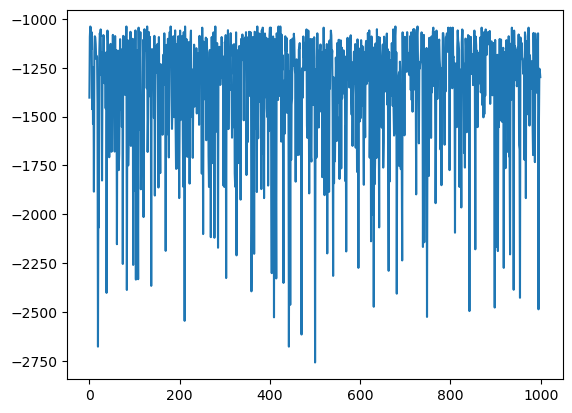

In [5]:
# Initialize the environment and agent
env = CliffBoxGridWorld()
agent = RandomAgent(env, num_episodes=1000)
rewards = agent.learn()

# Plot the learning curve
plt.plot(rewards)

Train your own agent!

## Agent Training

The agent is trained for 5000 episodes, with an initial epsilon value of 0.3, alpha value of 0.2 and gamma value of 0.99. These values were found through experimentation. An additional agent, _agent\_no\_cos_ is also trained to visualize the effects of adding the cosine annealing schedule.

In [6]:
env = CliffBoxGridWorld()
agent = RLAgent(env, num_episodes=5000, epsilon=0.3, alpha=0.2, gamma=0.99, use_cosine=True)
agent_no_cos = RLAgent(env, num_episodes=5000, epsilon=0.3, alpha=0.2, gamma=0.99, use_cosine=False)
# agent = RLAgent(env, num_episodes=1000, epsilon=0.1, alpha=0.1, gamma=0.99)
rewards = agent.learn()
rewards_no_cos = agent_no_cos.learn()

## Learning progress plot

The episode rewards are plotted against the episides in the graph below, we see that the algorithm converges after about 4000 epochs using cosine annealing.

The secomd graph shows the learning progress without cosine annealing. We see that this results in much more noise, and the algorithm does not converge at the 5000 epochs set. This is because of the complexity of the environment, and that the agent continues to use random actions with a probability of epsilon at each state, resulting in a very low success rate for episodes.

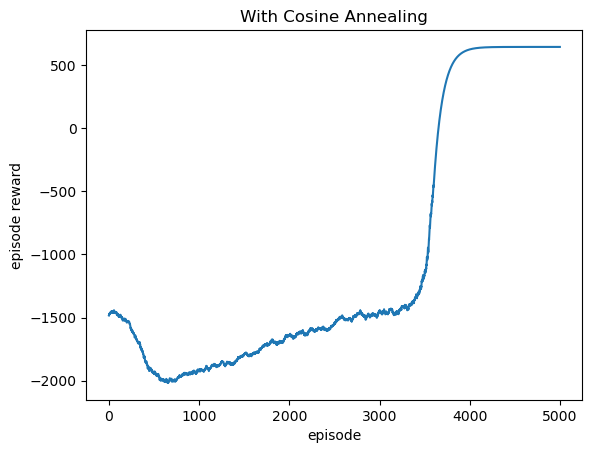

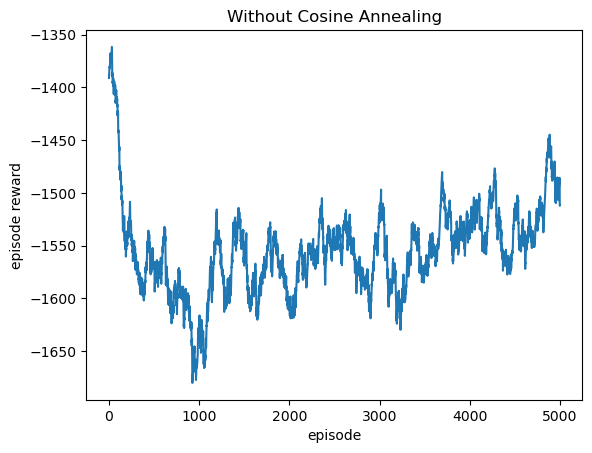

In [7]:
# Smooth plot
# RLAgent with cos annealing
weight=0.99
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# agent_no_cos
last_no_cos = rewards_no_cos[0]
smoothed_no_cos = []
for v in rewards_no_cos:
    smoothed_val = last_no_cos * weight + (1 - weight) * v
    smoothed_no_cos.append(smoothed_val)
    last_no_cos = smoothed_val

# Plot the learning curve
plt.figure(1)
plt.title("With Cosine Annealing")
plt.xlabel("episode")
plt.ylabel("episode reward")
plt.plot(smoothed)
plt.figure(2)
plt.title("Without Cosine Annealing")
plt.xlabel("episode")
plt.ylabel("episode reward")
plt.plot(smoothed_no_cos)

You need to complete the following method to visualize your training results.

## Visualization

The visualize() function is used to display the V-table and plot the learned policy step-by-step for the agent.

The V-table values were calculated by taking the average of all Q-values for each agent position. All the box positions were considered for each agent position, and an average of these values was taken. Comments are added in the code for ease of reading.

In the learned policy, the environment, the corresponding action, the current state, and the reward for the action is shown for each time step. It can be seen that the agent does indeed find the most efficient path to push the box to the goal position. 

In [8]:
def visualize(q_table):
    # pass
    # TODO: Visualize learned V-table and policy.
    # for ... in q_table.items():
    #     v_table[key[0]].append(np.mean(list(value.values())))
    #     policy[key[0]].append(actions[np.argmax([value[i] for i in range(1, 5)])])

    # init environment
    env = CliffBoxGridWorld(render=True)

    print("V-table:")
    # init v table
    v_table = np.zeros((env.world_height, env.world_width), dtype=np.float64)

    # iterate q-table states, and their corresponding actions
    for state_item in q_table.items():
        # self.q_table[(agent_x, agent_y, box_x, box_y)]
        # init empty list to store all Q-values for each agent position
        q_values = []
        # iterate box across world width
        for box_x in range(0, env.world_width):
            # iterate box across world height
            for box_y in range(0, env.world_height):
                # get q values all actions in this state
                state_q_values = q_table[(state_item[0][0], state_item[0][1], box_y, box_x)].values()
                # add q values to q values list
                for v in state_q_values:
                    q_values.append(v)

        # print(np.mean(q_values))
        # add mean of q values list to v table entry
        v_table[state_item[0][0]][state_item[0][1]] = np.mean(q_values)

    # np.set_printoptions(precision=2, suppress=True, linewidth=np.inf)
    # print(v_table)

    # convert to pandas dataframe for pretty printing
    df_v_table = pd.DataFrame(data=v_table)
    
    # set pandas print options and display Q-values
    with pd.option_context('display.max_rows', 500, 'display.max_columns', 500,\
                           'display.width', 1000, "display.precision", 3):
        print(df_v_table)
        print()


    print("Learned Policy:")
    print("Init World")

    state = env.reset()
    done = False
    
    env.print_world()
    print()

    while not done:
        # get max q value for current state
        max_value= max(q_table[state].values())
        # random choice to handle cases where Q-values for 2 actions are the same
        action = np.random.choice([k for k, v in q_table[state].items() if v == max_value])
        # action = max(q_table[state], key=lambda key: q_table[state][key])
        
        # advance to next state
        next_state, reward, done, info = env.step(action)

        env.print_world()
        print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
        print()

        state = next_state

visualize(agent.q_table)

V-table:
       0       1       2       3       4       5       6       7       8       9       10      11      12      13
0 -41.960 -42.350 -42.565 -42.859 -40.470 -53.993   0.000   0.000 -47.425 -34.693 -34.015 -32.737 -28.992 -27.212
1 -39.855 -37.494 -38.208 -54.590 -38.934 -52.421   0.000   0.000 -47.245 -32.670 -31.457 -30.839 -42.457 -26.901
2 -40.043 -38.654 -57.031   0.000 -54.532 -51.334   0.000   0.000 -49.150 -33.629 -33.053 -59.317   0.000 -39.019
3 -42.459 -38.983 -55.960   0.000 -50.609 -51.899   0.000 -62.955 -37.610 -37.143 -45.044   0.000   0.000 -42.023
4 -42.397 -39.057 -54.018   0.000 -49.679 -37.862 -49.666 -36.415 -35.211 -34.913 -45.801   0.000   0.000 -41.006
5 -40.200 -40.303 -60.589   0.000 -53.792 -40.689 -40.398 -39.198 -38.421 -35.239 -47.571   0.000   0.000 -40.616

Learned Policy:
Init World
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'

## References

[1] I. Loshchilov and F. Hutter, “SGDR: STOCHASTIC GRADIENT DESCENT WITH WARM RESTARTS,” ICLR 2017, May 2017. 